<a href="https://colab.research.google.com/github/na-na15/Answer-Correctness-Prediction/blob/main/AnswerCorrectnesPredictioncolab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Riiid! Answer Correctness Prediction**
*Track knowledge states of 1M+ students in the wild*

Student name: Nastaran Nazemian

Student pace: Part Time

Scheduled project review date/time: 01/05/2021 at 11:00 AM PST

Instructor name: Lindsey Berlin

Blog post URL:


## **Table of Contents**


*  Introduction
*  Introduce Data Set 
*  Gather and Scrape the Data
*  Modeling
  1. XGB
  2. CatBoosting
  3. LightBoosting
  4. Multi Layer Neural Network
  5. Embedding Neural Network

*  Conclusion
*  Feature Works


















### **Introduction:**

Education is one of the most challenging topics, especially recently during the COVID-19 pandemic. I see around myself many teachers and students have a hard time to teach and learn different topics in online classes.

In the traditional education systems normally teachers or instructors monitor and assess student’s knowledge based on their skills and abilities. In case students need more help or practice, their teachers would assist them. Imagining the situation that each student can trace her/his knowledge. In other words, the knowledge has been separated in a different level of skills, and the sequences of learning activities help leaning progress. Now, each student can obtain requirement skills based on her/his knowledge and abilities before moving to the next complex topic. In this way, students just spend their time to improve their weakness and get more attendance, engagement and individualized attention. Therefore, in modifying what student’s need in their next steps for learning, it is necessary to track, measure, and predict student’s changing knowledge, state, thereby personalizing the design. For having the more effective automated tutoring systems the student’s knowledge state should be modeled which is called knowledge tracing and replace the traditional ways that instructors use to assess the students’ performance with sequence of formative and summative learning activities. In knowledge tracing, machine learning algorithms help us to model student performance which has a high educational impact on automated tutoring systems.

Riiid Labs, an AI solutions provider delivering creative disruption to the education market, empowers global education players to rethink traditional ways of learning leveraging AI. With a strong belief in equal opportunity in education, Riiid launched an AI tutor based on deep-learning algorithms in 2017 that attracted more than one million South Korean students. This year, the company released EdNet, the world’s largest open database for AI education containing more than 100 million student interactions.




In this notbooke, I am going to create algorithms for "Knowledge Tracing," the modeling of student knowledge over time. The goal is to accurately predict how students will perform on future interactions.


### **Introduce Files:**

***train.csv***

**row_id:** (int64) ID code for the row.

**timestamp:** (int64) the time in milliseconds between this user interaction and the first event completion from that user.

**user_id:** (int32) ID code for the user.

**content_id:** (int16) ID code for the user interaction

**content_type_id:** (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

**task_container_id:** (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

**user_answer:**(int8) the user's answer to the question, if any. Read -1 as null, for lectures.

**answered_correctly:** (int8) if the user responded correctly. Read -1 as null, for lectures.

**prior_question_elapsed_time:** (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.

**prior_question_had_explanation:**(bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

***questions.csv*** 

metadata for the questions posed to users.

**question_id:** foreign key for the train/test content_id column, when the content type is question (0).

**bundle_id:** code for which questions are served together.

**correct_answer:** the answer to the question. Can be compared with the train user_answer column to check if the user was right.

**part:** the relevant section of the TOEIC test.

**tags:** one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

***lectures.csv***

 metadata for the lectures watched by users as they progress in their education.

**lecture_id:** foreign key for the train/test content_id column, when the content type is lecture (1).

**part:** top level category code for the lecture.

**tag:** one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

**type_of:** brief description of the core purpose of the lecture

***example_test_rows.csv***

Three sample groups of the test set data as it will be delivered by the time-series API. The format is largely the same as train.csv. There are two different columns that mirror what information the AI tutor actually has available at any given time, but with the user interactions grouped together for the sake of API performance rather than strictly showing information for a single user at a time. Some users will appear in the hidden test set that have NOT been presented in the train set, emulating the challenge of quickly adapting to modeling new arrivals to a website.

**prior_group_response (string):** provides all of the user_answer entries for previous group in a string representation of a list in the first row of the group. All other rows in each group are null. If you are using Python, you will likely want to call eval on the non-null rows. Some rows may be null, or empty lists.

**prior_group_answers_correct (string):** provides all the answered_correctly field for previous group, with the same format and caveats as prior_group_responses. Some rows may be null, or empty lists.

In [ ]:
! ls

sample_data


In [ ]:
#For connect the colab in my google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Install Libraries**

In [ ]:
! pip install catboost
! pip install tensorflow>=2.3.0
! pip install scikeras>=0.1.8
! pip install --upgrade xgboost

     |████████████████████████████████| 65.8MB 110kB/s 
     |████████████████████████████████| 157.5MB 41kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


**Import Libraries**

In [ ]:
from google.colab import drive
import zipfile
import glob
from datetime import datetime
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore", message="unclosed", category=ResourceWarning)

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, auc , plot_roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
# from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
import catboost as catb
import lightgbm as lgb 

# from catboost import CatBoostClassifier, cv, Pool
# from sklearn.svm import SVC

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, Input, Reshape, Concatenate, Activation
from keras.wrappers.scikit_learn import KerasClassifier


### **Gather and Scrape the Data**

There are 2 ways for reading the data. One by using the API and anothre one by uploding the zipfile and read zipfile. First lets I use the API for reading my data. 

In [ ]:
#response = requests.get("https://github.com/Kaggle/kaggle-api")
#Everything went okay, and the result has been returned (if any).
#print(response.status_code)

In below I am going to read a zip file. and make them as a csv file. In the next step I am going to create my data frames. 


In [ ]:
 #Unzip files
 !unzip '/content/gdrive/My Drive/Colab Notebooks/Answer-Correctness-Prediction/riiid-test-answer-prediction.zip'

In [ ]:
# example_sample_df = pd.read_csv('example_sample_submission.csv')
# lectures_df = pd.read_csv('lectures.csv')
# questions_df = pd.read_csv('questions.csv')
# example_test_df = pd.read_csv('example_test.csv)
train_df = pd.read_csv('train.csv')


In [ ]:
# print('example_sample_df shape:', example_sample_df.shape)
# print('lectures_df shape:', lectures_df.shape)
# print('questions_df shape:', questions_df.shape)
# print('example_test_df shape:', example_test_df.shape)
print('train_df shape:', train_df.shape)

train_df shape: (101230332, 10)


In [ ]:
# print('example_sample_df columns:', example_sample_df.columns)
# print('lectures_df columns:', lectures_df.columns)
# print('questions_df columns:', questions_df.columns)
# print('example_test_df columns:', example_test_df.columns)
print('train_df columns:', train_df.columns)

train_df columns: Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation'],
      dtype='object')


In this section, I will dive deeper into the train.csv file. 

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


In [ ]:
train_df.describe()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,9.887879e+07
mean,5.061517e+07,7.703644e+09,1.076732e+09,5.219605e+03,1.935222e-02,9.040624e+02,1.376123e+00,6.251644e-01,2.542381e+04
std,2.922268e+07,1.159266e+10,6.197163e+08,3.866359e+03,1.377596e-01,1.358302e+03,1.192896e+00,5.225307e-01,1.994815e+04
min,0.000000e+00,0.000000e+00,1.150000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00
25%,2.530758e+07,5.243436e+08,5.408116e+08,2.063000e+03,0.000000e+00,1.040000e+02,0.000000e+00,0.000000e+00,1.600000e+04
50%,5.061517e+07,2.674234e+09,1.071781e+09,5.026000e+03,0.000000e+00,3.820000e+02,1.000000e+00,1.000000e+00,2.100000e+04
75%,7.592275e+07,9.924551e+09,1.615742e+09,7.425000e+03,0.000000e+00,1.094000e+03,3.000000e+00,1.000000e+00,2.966600e+04
max,1.012303e+08,8.742577e+10,2.147483e+09,3.273600e+04,1.000000e+00,9.999000e+03,3.000000e+00,1.000000e+00,3.000000e+05


In [ ]:
#Number of the uniqe user
list_user_id = set(train_df.user_id)
print('The number of the unique users:', len(list_user_id))
# print(type(list_user_id))

#Number of the uniqe content
list_content = set(train_df.content_id)
print('The number of the unique content:', len(list_content))

#Number of Lectures and Questions in the whole dataset.
ques_Lec = {0:'Question',1:'Lecture'}
train_df.groupby(train_df['content_type_id'].map(ques_Lec)).agg({'content_id': 'count'})


The number of the unique users: 393656
The number of the unique content: 13782


,content_id
content_type_id,
Lecture,1959032
Question,99271300


According  to the results my train data frame includes 39,656 unique users,13,782 different contents, 99,271,300 total question answered, and 1,959,032 lectures watched.

Since our dataset has more than 100 million records which include 39,656. users. I will get a random sample from the users and consider their performans. 

In [ ]:
# create a random sample of train_df. 
sample_size = int(round(len(list_user_id)*0.1,0))
type(sample_size)
sample_list_user_id = random.sample(list_user_id, sample_size)
print('Number of the users are selected for my random sample:',len(sample_list_user_id))
sampled_train_df = train_df[train_df.user_id.isin(sample_list_user_id) ]
sampled_train_df.head()

Number of the users are selected for my random sample: 39366


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
17668,17668,0,215672,7900,0,0,2,0,NaN,NaN
17669,17669,27053,215672,7876,0,1,2,0,22000.0,False
17670,17670,51558,215672,175,0,2,0,0,23000.0,False
17671,17671,71568,215672,1278,0,3,3,1,21000.0,False
17672,17672,132631,215672,2064,0,4,1,1,17000.0,False


In [ ]:
# Reset the index
sampled_train_df.reset_index(drop = True, inplace= True)
sampled_train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,17668,0,215672,7900,0,0,2,0,NaN,NaN
1,17669,27053,215672,7876,0,1,2,0,22000.0,False
2,17670,51558,215672,175,0,2,0,0,23000.0,False
3,17671,71568,215672,1278,0,3,3,1,21000.0,False
4,17672,132631,215672,2064,0,4,1,1,17000.0,False


prior_question_elapsed_time column shows the average time in milliseconds it took a user to answer each question in the previous question bundle. I will create a column, called time which is going to show the average time it took a user to answer each question in the current bundle. 


In [ ]:
'''
Already all of the records are sorted  by user_id and task_container_id,
since the prior_question_elapsed_time shows the time spent for previous questions,
when shifting the time elapsed for previous row, for the last task the time will be null. 
'''
sampled_train_df['time'] = None
number_rows =sampled_train_df.shape[0]
sampled_train_df.time.iloc[number_rows-1] = None # 39365 => sampled_train_df.len - 1
for i in range(number_rows-2,-1,-1): # 39365 => sampled_train_df.len - 2
  if sampled_train_df.at[i, 'task_container_id'] != sampled_train_df.at[i+1, 'task_container_id']:
    sampled_train_df.at[i, 'time'] = sampled_train_df.at[i+1, 'prior_question_elapsed_time']
  else:
    sampled_train_df.at[i, 'time'] = sampled_train_df.at[i+1, 'time']

# sampled_train_df.head(30)
# # print(user_124.time)

prior_question_had_explanation column shows whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle. I will create a column, called question_had_explanation which is going to show whether or not the user saw an explanation of each question.

In [ ]:
'''
Already all of the records are sorted  by user_id and task_container_id,
since the prior_question_elapsed_explanation shows whether or not the user 
saw an explanation and the correct response(s) after answering the previous question bundle.
By shifting the question_elapsed_explanation for previous row, for the last task the time will be null. 
'''
sampled_train_df['question_had_explanation'] = None
number_rows =sampled_train_df.shape[0]
sampled_train_df.time.iloc[number_rows-1] = None # 39365 => sampled_train_df.len - 1
for i in range(number_rows-2,-1,-1): # 39365 => sampled_train_df.len - 2
  if sampled_train_df.at[i, 'task_container_id'] != sampled_train_df.at[i+1, 'task_container_id']:
    sampled_train_df.at[i, 'question_had_explanation'] = sampled_train_df.at[i+1, 'prior_question_had_explanation']
  else:
    sampled_train_df.at[i, 'question_had_explanation'] = sampled_train_df.at[i+1, 'question_had_explanation']

In [ ]:
# sampled_train_df.loc[sampled_train_df.user_id == 2147470770].tail(10)

In [ ]:
#Convert the time columns type to int
sampled_train_df.time = sampled_train_df.time.astype('Int64')

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Since creating columns time  and question_had_explanation took time,  I will save my new data set. 

In [ ]:
#Save the new dataframe in my google drive
drive.mount('/content/gdrive')
with open('/content/gdrive/My Drive/Colab Notebooks/Answer-Correctness-Prediction/sampled_df_time_explanation.csv', 'w') as f:
  sampled_train_df.to_csv(f)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Read the new dataframe from my google drive
sampled_df_time_explanation = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Answer-Correctness-Prediction/sampled_df_time_explanation.csv')

In [ ]:
sampled_df_time_explanation.head()

In [ ]:
sampled_df_time_explanation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10248725 entries, 0 to 10248724
Data columns (total 13 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unnamed: 0                      int64  
 1   row_id                          int64  
 2   timestamp                       int64  
 3   user_id                         int64  
 4   content_id                      int64  
 5   content_type_id                 int64  
 6   task_container_id               int64  
 7   user_answer                     int64  
 8   answered_correctly              int64  
 9   prior_question_elapsed_time     float64
 10  prior_question_had_explanation  object 
 11  time                            float64
 12  question_had_explanation        object 
dtypes: float64(2), int64(9), object(2)
memory usage: 1016.5+ MB


In [ ]:
#Convert time from millsecond to second, and drop Unnamed column
sampled_df_time_explanation.time =sampled_df_time_explanation.time/1000
sampled_df_time_explanation.drop(columns=['Unnamed: 0'], axis=1, inplace= True)

In [ ]:
sampled_df_time_explanation.describe().round(2)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,time
count,1.024872e+07,1.024872e+07,1.024872e+07,10248725.00,10248725.00,10248725.00,10248725.00,10248725.00,10011038.00,9860223.00
mean,5.067783e+07,7.513110e+09,1.078087e+09,5243.54,0.02,932.68,1.38,0.63,25486.57,25.89
std,2.938043e+07,1.136648e+10,6.230622e+08,3859.88,0.14,1390.21,1.19,0.52,20269.00,20.66
min,1.766800e+04,0.000000e+00,2.156720e+05,0.00,0.00,0.00,-1.00,-1.00,0.00,0.00
25%,2.519547e+07,5.441570e+08,5.386700e+08,2065.00,0.00,107.00,0.00,0.00,16000.00,16.00
50%,5.035354e+07,2.698661e+09,1.066444e+09,5071.00,0.00,390.00,1.00,1.00,21000.00,21.00
75%,7.664674e+07,9.585016e+09,1.631849e+09,7480.00,0.00,1138.00,3.00,1.00,29666.00,30.00
max,1.012276e+08,8.362039e+10,2.147415e+09,32736.00,1.00,9999.00,3.00,1.00,300000.00,300.00


In [ ]:
sampled_df_time_explanation.isnull().sum()

row_id                                 0
timestamp                              0
user_id                                0
content_id                             0
content_type_id                        0
task_container_id                      0
user_answer                            0
answered_correctly                     0
prior_question_elapsed_time       237687
prior_question_had_explanation     39250
time                              388502
question_had_explanation           65682
dtype: int64

In [ ]:
#Fill missing data
# sampled_df_time_explanation = sampled_df_time_explanation.loc[sampled_df_time_explanation.content_type_id ==0]
# sampled_df_time_explanation.drop(columns='Unnamed: 0', axis =1, inplace=True)
sampled_df_time_explanation.prior_question_elapsed_time.fillna(0, inplace= True)
sampled_df_time_explanation['time'] =sampled_df_time_explanation.groupby(['content_id'], sort=False)['time'].apply(lambda x: x.fillna(x.mean()))
sampled_df_time_explanation['question_had_explanation'] = sampled_df_time_explanation.groupby(['user_id'], sort=False)['question_had_explanation'].apply(lambda x: x.fillna(x.mode()[0]))
sampled_df_time_explanation.prior_question_had_explanation.fillna(False, inplace = True)

print(sampled_df_time_explanation.shape)
sampled_df_time_explanation.isnull().sum()

(10248725, 12)


row_id                            0
timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
time                              0
question_had_explanation          0
dtype: int64

In [ ]:
#Percentage of the correct, Incorrect answers in dataset
answer_dis = sampled_df_time_explanation['answered_correctly'].value_counts().to_frame()
answer_dis['percent'] = answer_dis['answered_correctly'].apply(lambda x : round(100*float(x) / len(sampled_df_time_explanation), 2))
answer_dis = answer_dis.rename(index = {1 : 'Correct answer', 0 : 'Incorrect answer', -1:'Lecture'}, columns={'answered_correctly': 'count_correct_Answer'})
answer_dis



,count_correct_Answer,percent
Correct answer,6625170,64.64
Incorrect answer,3425118,33.42
Lecture,198437,1.94


In [ ]:
answer_dis.count_correct_Answer.sum()

10248725

<function matplotlib.pyplot.show>

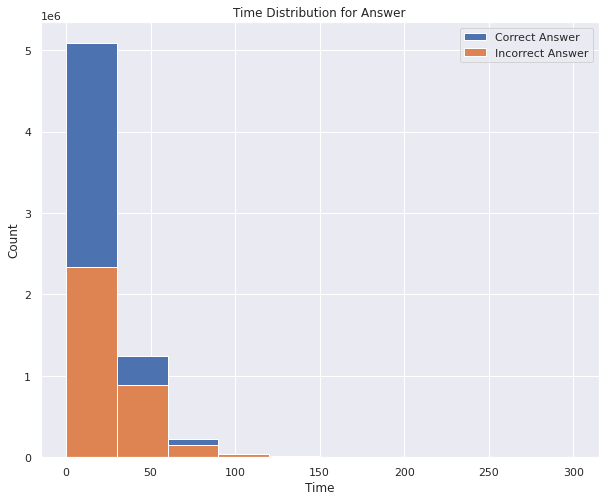

In [ ]:
#Plot Time Distribution by Correct and Incorrect answers
x1 = sampled_df_time_explanation.time.loc[sampled_df_time_explanation.answered_correctly == 1]
x2 = sampled_df_time_explanation.time.loc[sampled_df_time_explanation.answered_correctly == 0]
plt.figure(figsize = (10,8))
plt.hist(x1,label= "Time Distribution for Correct Answer")
plt.hist(x2, label= "Time Distribution for Incorrect Answer")
plt.legend(labels=['Correct Answer','Incorrect Answer'])
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Time Distribution for Answer')
plt.show

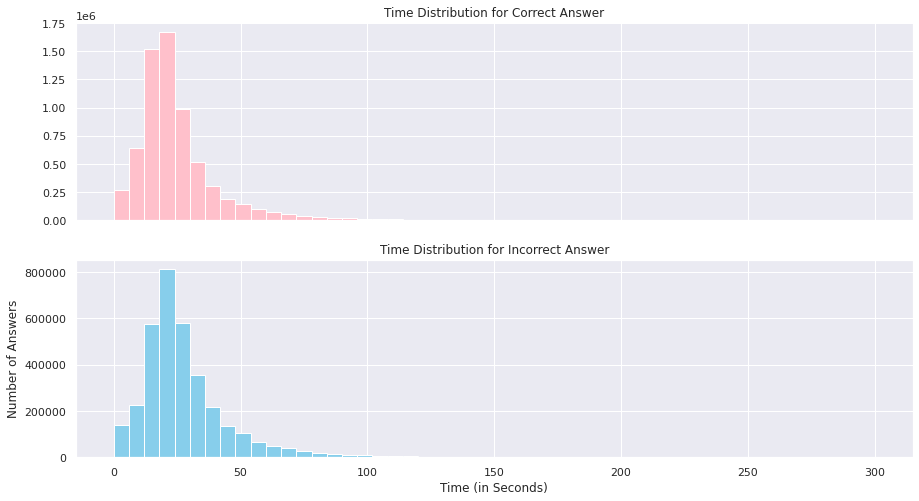

In [ ]:
# Compere time distribution for incorrect and correct answers
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))

ax1.hist(x1, bins = 50, color = 'pink')
ax1.set_title('Time Distribution for Correct Answer')

ax2.hist(x2, bins = 50, color = 'skyblue')
ax2.set_title('Time Distribution for Incorrect Answer')

# ax3.hist(x3, bins = 50, color = 'yellow')
# ax3.set_title('Time Distribution for Lecture')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Answers')
plt.show()

According to the last two plots, time spent  for Incorrect answers and Correct answers have the same distribution while the time spent on the correct answer is more than the Incorrect answer.Based on the plot above 98% of content are questions and less than 2% are lectures.


In [ ]:
list_task_id = set(train_df.task_container_id)
len(list_task_id)

10000

[Text(0, 0, 'Questions'), Text(0, 0, 'Lucture')]

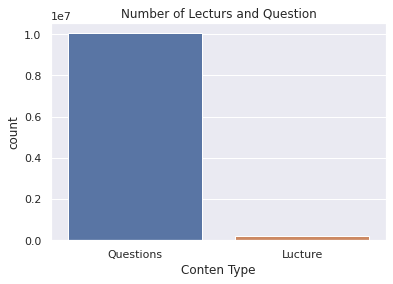

In [ ]:
#Plot Number of the Lectures and Questions
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="content_type_id", data=sampled_df_time_explanation)
ax.set_title('Number of Lecturs and Question')
ax.set_xlabel('Conten Type')
ax.set_xticklabels(["Questions","Lucture"])


In [ ]:
#Table of the percentage of the Questions and Lectures
content_count = sampled_df_time_explanation['content_type_id'].value_counts().to_frame()
content_count['percent'] = content_count['content_type_id'].apply(lambda x : round(100*x / sampled_df_time_explanation.shape[0], 2))
content_count = content_count.rename(index = {0: 'Question_Posted', 1: 'Lecture'})
content_count


,content_type_id,percent
Question_Posted,10050288,98.06
Lecture,198437,1.94


Based on the plot above 98% of content are questions and less than 2% are lectures. 

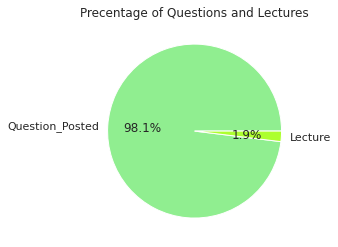

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(content_count.percent, labels=content_count.index, autopct='%1.1f%%', colors = ['lightgreen','greenyellow'])
plt.title('Precentage of Questions and Lectures')
plt.show()



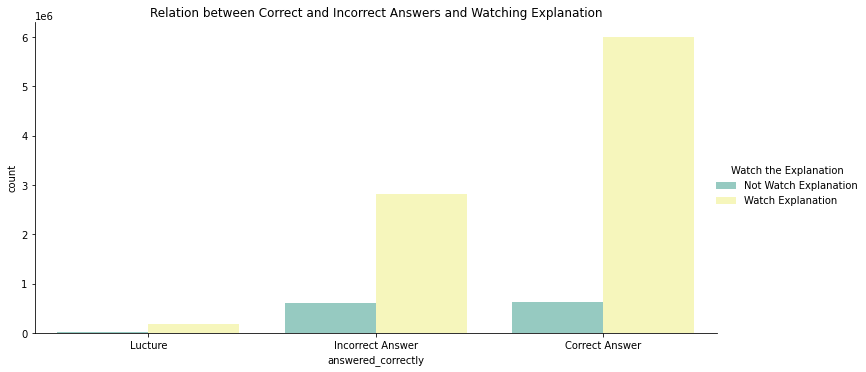

In [62]:
#Plot Watching the Explanation by Correct and Wrong Answers
g = sns.catplot(x="answered_correctly", 
                hue="question_had_explanation",
                data=sampled_df_time_explanation[sampled_df_time_explanation.question_had_explanation.notnull()],
                orient="h", palette="Set3",
                kind="count",
                aspect=2).set(title = "Relation between Correct and Incorrect Answers and Watching Explanation")
g.set_xticklabels(["Lucture", "Incorrect Answer", "Correct Answer"])
# title
new_title = 'Watch the Explanation'
g._legend.set_title(new_title)
# replace labels
new_labels = ['Not Watch Explanation', 'Watch Explanation']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# sns.plt.show()

In [ ]:
sampled_df_time_explanation.shape

(10152966, 12)

In [ ]:
#Create new dataframe for considering the top 30 activate users
answer_df = sampled_df_time_explanation.pivot_table(values= 'row_id', index='user_id', columns='answered_correctly', aggfunc='count')
answer_df.reset_index(inplace=True)
answer_df.rename(columns={1:'correct_number', -1:'lecture', 0:'wrong_number'}, inplace=True)

content_df = sampled_df_time_explanation.pivot_table(values= 'row_id', index='user_id', columns='content_type_id', aggfunc='count', fill_value =0)
content_df.reset_index(inplace=True)
content_df.rename(columns={0:'Question_Posted', 1:'Lecture',}, inplace=True)

time_df = sampled_df_time_explanation.pivot_table(values= 'timestamp', index='user_id', columns='content_type_id', aggfunc='max', fill_value =0)
time_df.reset_index(inplace=True)
time_df.rename(columns={0:'Question_Posted', 1:'Lecture',}, inplace=True)

max_task_df = sampled_df_time_explanation.pivot_table(values= 'task_container_id', index='user_id', aggfunc='max', fill_value =0)
max_task_df.reset_index(inplace=True)

explanation_df = sampled_df_time_explanation.pivot_table(values ='row_id', index='user_id', columns='question_had_explanation', aggfunc= 'count')
explanation_df.reset_index(inplace=True)
explanation_df.rename(columns={False:'not_watch', True:'watch'}, inplace=True)



In [ ]:
user_df=answer_df.user_id.to_frame()
user_df['correct_number'] = answer_df.correct_number
user_df['wrong_number'] = answer_df.wrong_number
user_df['lucture_number'] = content_df.Lecture
user_df['question_posted'] = content_df.Question_Posted
user_df['total_time_lucture'] = time_df.Lecture/1000
user_df['total_time_question'] = time_df.Question_Posted/1000
user_df['max_task'] = max_task_df.task_container_id
user_df['no_watch_explanation'] = explanation_df.not_watch
user_df['watch_explanation'] = explanation_df.watch

In [ ]:
print('User_df Shape:', user_df.shape)
print(user_df.info())
user_df.describe()

User_df Shape: (39366, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39366 entries, 0 to 39365
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               39366 non-null  int64  
 1   correct_number        39351 non-null  float64
 2   wrong_number          39345 non-null  float64
 3   lucture_number        39366 non-null  int64  
 4   question_posted       39366 non-null  int64  
 5   total_time_lucture    39366 non-null  float64
 6   total_time_question   39366 non-null  float64
 7   max_task              39366 non-null  int64  
 8   no_watch_explanation  39201 non-null  float64
 9   watch_explanation     31774 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 3.0 MB
None


,user_id,correct_number,wrong_number,lucture_number,question_posted,total_time_lucture,total_time_question,max_task,no_watch_explanation,watch_explanation
count,3.936600e+04,39351.000000,39345.000000,39366.000000,39366.000000,3.936600e+04,3.936600e+04,39366.000000,39201.000000,31774.000000
mean,1.078695e+09,168.360906,87.053450,5.040822,255.303765,2.783226e+06,5.123313e+06,200.949703,31.156169,282.044754
std,6.211856e+08,532.821508,235.832449,16.434975,751.590751,7.995527e+06,1.050892e+07,570.717377,56.250852,797.369400
min,2.156720e+05,1.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000
25%,5.413706e+08,11.000000,12.000000,0.000000,30.000000,0.000000e+00,1.124440e+03,16.000000,10.000000,11.000000
50%,1.082744e+09,23.000000,22.000000,0.000000,40.000000,0.000000e+00,3.754581e+05,34.000000,21.000000,41.000000
75%,1.620642e+09,96.000000,57.000000,2.000000,155.000000,9.274590e+05,4.571438e+06,135.000000,30.000000,195.000000
max,2.147415e+09,13034.000000,8112.000000,397.000000,16169.000000,8.362039e+07,8.362037e+07,9999.000000,2060.000000,15956.000000


In [ ]:
# Find and Fill the missing data
user_df['correct_number'] = user_df['correct_number'].fillna(value =
                                                             user_df['question_posted']-user_df['wrong_number'])
user_df['wrong_number'] = user_df['wrong_number'].fillna(value =
                                                             user_df['question_posted']-user_df['correct_number'])
user_df['no_watch_explanation'] = user_df['no_watch_explanation'].fillna(value= user_df['question_posted']-user_df['watch_explanation'])
user_df['watch_explanation'] =user_df['watch_explanation'].fillna(value= user_df['question_posted']-user_df['no_watch_explanation'])
user_df['watch_explanation'] =user_df.watch_explanation -user_df.lucture_number



In [ ]:
 user_df.isnull().sum()

user_id                 0
correct_number          0
wrong_number            0
lucture_number          0
question_posted         0
total_time_lucture      0
total_time_question     0
max_task                0
no_watch_explanation    0
watch_explanation       0
dtype: int64

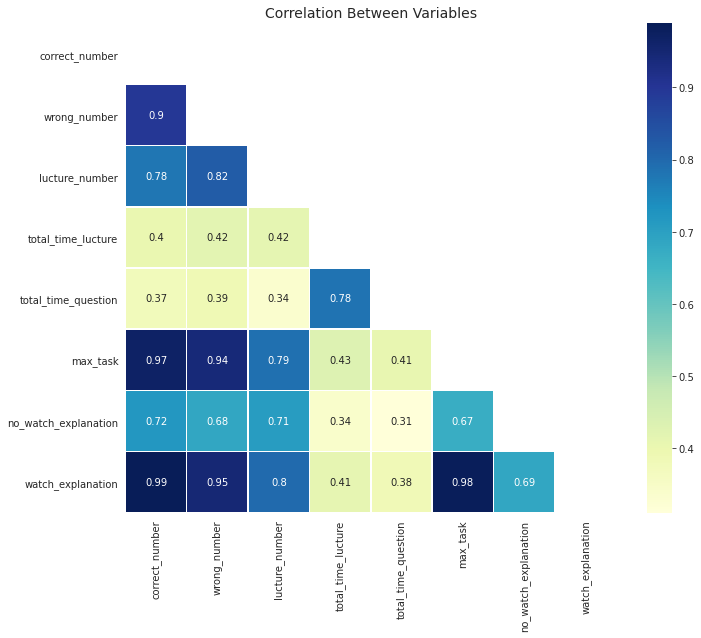

In [ ]:
# get correlations
corr_user_df = user_df.drop(columns=['user_id','question_posted'],axis = 1).corr()
mask = np.zeros_like(corr_user_df)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
  fig, ax = plt.subplots(figsize=(11, 9))
  sns.heatmap(corr_user_df, annot=True, linewidths=.5, mask=mask, cmap="YlGnBu")
  ax.set_title('Correlation Between Variables', fontsize=14)
plt.show()

According to the heatmap, the number of tasks done by a user has a strong and direct relation with the number of questions, correct answers and incorrect answers. The nice point in this plot is the positive relation between the number of the lectures are seen and the wrong answers. 

#### Most Active Users:

In this part, I am going to consider active users’ performance. First, I will define performance as the percentage of correctly answered questions. Sorting all users this way does not add a lot of value, as there are users with good performance who have answered only a few questions.I am going to choose the top 25% of users with the highest number of answered questions, which have answered more than 153 questions. Remaining users are sorted by their performance as defined earlier. For having a better illustration I am going to use the top 40 active users.



In [ ]:
user_df['percent_correct _answer'] =user_df['correct_number']/user_df['question_posted']
active_user = user_df[['user_id', 'question_posted','correct_number','percent_correct _answer','wrong_number','total_time_lucture','total_time_question']].loc[user_df.question_posted > 153]
active_user =active_user.sort_values(by=['percent_correct _answer'], ascending= False).head(40)
active_user.head()

,user_id,question_posted,correct_number,percent_correct _answer,wrong_number,total_time_lucture,total_time_question
20907,1149596278,170,160.0,0.941176,10.0,0.000,1.170546e+07
26490,1452809790,253,237.0,0.936759,16.0,0.000,8.453326e+05
27101,1487963810,515,482.0,0.935922,33.0,183933.679,2.390095e+05
28551,1565557588,228,213.0,0.934211,15.0,0.000,6.804768e+05
31944,1747921905,2458,2291.0,0.932059,167.0,4328891.119,1.346174e+07


Text(0.5, 0, 'Counts')

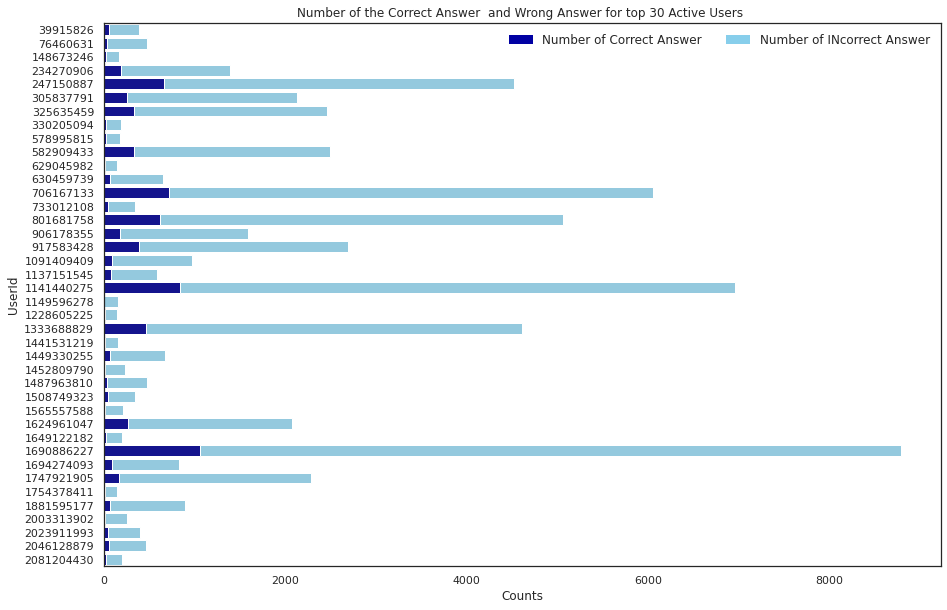

In [ ]:
#Compere the number of the questions answered and correct answer
sns.set_style("white")
sns.set_context({"figure.figsize": (15, 10)})
sns.barplot(x = active_user.correct_number, y = active_user.user_id, color = "skyblue", orient = 'h')
bottom_plot = sns.barplot(x = active_user.wrong_number, y = active_user.user_id, color = "#0000A1", orient= 'h')

topbar = plt.Rectangle((0,0),1,1,fc="skyblue", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Number of Correct Answer', 'Number of INcorrect Answer'], loc=1, ncol = 2, prop={'size':12})
l.draw_frame(False)
bottom_plot.set_title("Number of the Correct Answer  and Wrong Answer for top 30 Active Users ")
bottom_plot.set_ylabel("UserId")
bottom_plot.set_xlabel("Counts")

Text(0.5, 0, 'Counts')

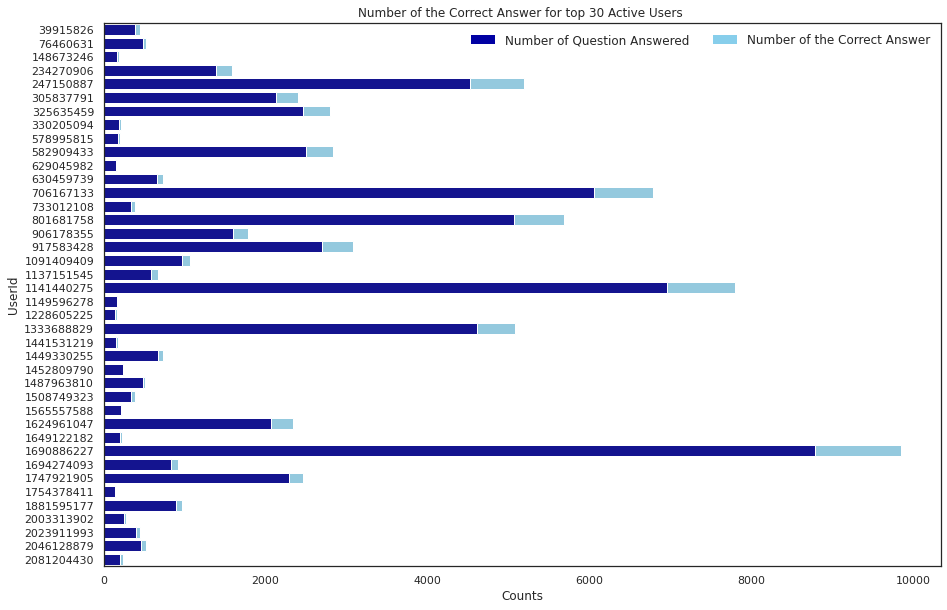

In [ ]:
# Compere the number of the wrong and correct answered in top 30 activate user
sns.set_style("white")
sns.set_context({"figure.figsize": (15, 10)})
sns.barplot(x = active_user.question_posted, y = active_user.user_id, color = "skyblue", orient = 'h')
bottom_plot = sns.barplot(x = active_user.correct_number, y = active_user.user_id, color = "#0000A3", orient= 'h')

topbar = plt.Rectangle((0,0),1,1,fc="skyblue", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Number of Question Answered', 'Number of the Correct Answer'], loc=1, ncol = 2, prop={'size':12})
l.draw_frame(False)
bottom_plot.set_title("Number of the Correct Answer for top 30 Active Users ")
bottom_plot.set_ylabel("UserId")
bottom_plot.set_xlabel("Counts")

### Modeling
I am going to use several algorithms to find the best model which has the highest Accuracy and AUC for my dataset.

In [ ]:
sampled_df_time_explanation = sampled_df_time_explanation.loc[sampled_df_time_explanation.answered_correctly != -1]
sampled_df_time_explanation.answered_correctly.unique()

array([0, 1])

In [ ]:
sampled_df_time_explanation.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,time,question_had_explanation
0,8805,0,45001,7900,0,0,3,0,NaN,NaN,24.0,False
1,8806,21730,45001,7876,0,1,0,0,24000.0,False,19.0,False
2,8807,42763,45001,175,0,2,2,1,19000.0,False,18.0,False
3,8808,61018,45001,1278,0,3,1,0,18000.0,False,15.0,False
4,8809,102918,45001,2065,0,4,0,0,15000.0,False,13.0,False


In [ ]:
y = sampled_df_time_explanation.answered_correctly
x = sampled_df_time_explanation.drop(columns=['answered_correctly','row_id','content_type_id','prior_question_elapsed_time','prior_question_had_explanation'], axis = 1)
# x = train_question_df.drop(columns=['answered_correctly','row_id','content_type_id'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=123)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(8040230, 7)
(8040230,)
(2010058, 7)
(2010058,)


In [ ]:
#Function

def perform_evaluate(title,cm,X,y):
    print(title)
    y_pred = cm.predict(X)
    print("accuracy: {}".format(accuracy_score(y,y_pred)))
    print("precision: {}".format(precision_score(y,y_pred)))
    print("recall: {}".format(recall_score(y,y_pred)))
    print("f1: {}".format(f1_score(y,y_pred,average='binary')))
    print(" ")

def grid_search(cm, param_grid, X_train,y_train,X_test, y_test ):
    rf_grid_search = GridSearchCV(cm, param_grid, cv=3,
                              return_train_score=True)
    rf_grid_search.fit(X_train, y_train)

    rf_grid_training_score = np.mean(rf_grid_search.cv_results_['mean_train_score'])
    rf_grid_score = rf_grid_search.score(X_test, y_test)
    rf_grid_search.best_params_
    print(f"Mean Training Score: {rf_grid_training_score :.2%}")
    print(f"Mean Test Score: {rf_grid_score :.2%}")
    print(f"Best Parameter Combination Found During Grid Search: {rf_grid_search.best_params_ :}")
    
    
# def randomized_search(cm, param_random, X_train,y_train,X_test, y_test ):
#     rf_grid_search = GridSearchCV(cm, param_random, cv=3,
#                               return_train_score=True)
#     rf_grid_search.fit(X_train, y_train)

#     rf_grid_training_score = np.mean(rf_grid_search.cv_results_['mean_train_score'])
#     rf_grid_score = rf_grid_search.score(X_test, y_test)
#     rf_grid_search.best_params_
#     print(f"Mean Training Score: {rf_grid_training_score :.2%}")
#     print(f"Mean Test Score: {rf_grid_score :.2%}")
#     print(f"Best Parameter Combination Found During Grid Search: {rf_grid_search.best_params_ :}")
        


def plot_roc(cm,X_train, y_train,X_test, y_test):
    fig, axes = plt.subplots(1,2, figsize = (10,6), sharey = 'row')
    y_pred_train = cm.predict(X_train)
    plot_roc_curve(cm, X_train, y_train, ax=axes[0])
    axes[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    axes[0].set_title("ROC Curve for Traning")
    
    
    y_pred_test = cm.predict(X_test)
    plot_roc_curve(cm, X_test, y_test, ax=axes[1])
    axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    axes[1].set_title("ROC Curve for Testing")
    
    plt.show() 

def Mean_Trainin_Testing_score(cm,X_train, y_train,X_test, y_test):
    cm.fit(X_train, y_train)

    cm_training_score = cm.score(X_train, y_train)
    cm_test_score = cm.score(X_test, y_test)
    print(f"Mean Training Score: {cm_training_score :.2%}")
    print(f"Mean Test Score: {cm_test_score :.2%}")
    
def roc_auc(cm,X_train,Y_train):
    y_pred_keras = nn_cf1.predict_proba(x_train).ravel()  
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_keras)
    roc_auc = auc(fpr, tpr)
    print(f"AUC:{roc_auc: .2%}")

#### XGBoostig

In [ ]:
#XGB base line
start_time = datetime.now()

parameters = {'tree_method': 'exact'}
# xgb_cfl = xgb.XGBClassifier(random_state=123, tree_method='exact')
xgb_cfl = xgb.XGBClassifier(random_state=123)
xgb_cfl.fit(x_train, y_train)
Mean_Trainin_Testing_score(xgb_cfl,x_train, y_train,x_test, y_test)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:47:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean Training Score: 69.20%
Mean Test Score: 69.17%
Duration: 0:09:39.965195


In [ ]:
start_time = datetime.now()

param_grid = {"learning_rate": [1 ,0.01],
             'max_depth': [3,6],
             'min_child_weight': [1, 5],
             'gamma':[0, 10]}

grid_search(xgb_cfl, param_grid,x_train,y_train,x_test, y_test )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:07:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:09:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:11:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:12:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [ ]:
start_time = datetime.now()
xgb_cfl = xgb.XGBClassifier(random_state=123,gamma=10, learning_rate=1, max_depth=6, min_child_weight=5)
xgb_cfl.fit(x_train, y_train)
Mean_Trainin_Testing_score(xgb_cfl,x_train, y_train,x_test, y_test)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:11:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean Training Score: 69.37%
Mean Test Score: 69.32%
Duration: 0:11:49.079839


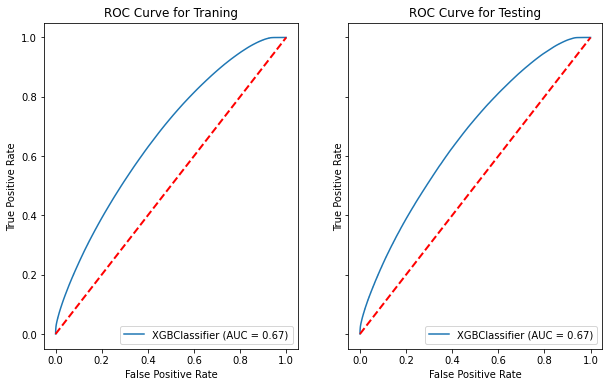

In [ ]:

plot_roc(xgb_cfl,x_train, y_train,x_test, y_test)

#### CatBoosting

In [ ]:
x_train.info()
categorical_features_indices =['content_id','user_answer','question_had_explanation','user_id']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8040230 entries, 6650700 to 5067380
Data columns (total 7 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   timestamp                 int64  
 1   user_id                   int64  
 2   content_id                int64  
 3   task_container_id         int64  
 4   user_answer               int64  
 5   time                      float64
 6   question_had_explanation  bool   
dtypes: bool(1), float64(1), int64(5)
memory usage: 437.1 MB


In [ ]:
start_time = datetime.now()

catb_cfl = catb.CatBoostClassifier(random_seed=123)
catb_cfl.fit(x_train, y_train,cat_features=categorical_features_indices)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Learning rate set to 0.479163
0:	learn: 0.0063686	total: 6.08s	remaining: 1h 41m 11s
1:	learn: 0.0023048	total: 11.1s	remaining: 1h 32m 19s
2:	learn: 0.0013104	total: 11.6s	remaining: 1h 4m 29s
3:	learn: 0.0012848	total: 12.6s	remaining: 52m 27s
4:	learn: 0.0012674	total: 16.2s	remaining: 53m 48s
5:	learn: 0.0012511	total: 20.2s	remaining: 55m 42s
6:	learn: 0.0012511	total: 20.9s	remaining: 49m 19s
7:	learn: 0.0012511	total: 21.3s	remaining: 44m 2s
8:	learn: 0.0012511	total: 22.1s	remaining: 40m 35s
9:	learn: 0.0012511	total: 22.9s	remaining: 37m 50s
10:	learn: 0.0012511	total: 23.3s	remaining: 34m 58s
11:	learn: 0.0012511	total: 23.9s	remaining: 32m 48s
12:	learn: 0.0012511	total: 24.3s	remaining: 30m 46s
13:	learn: 0.0012511	total: 24.9s	remaining: 29m 11s
14:	learn: 0.0012511	total: 25.3s	remaining: 27m 40s
15:	learn: 0.0012511	total: 25.8s	remaining: 26m 29s
16:	learn: 0.0012510	total: 26.3s	remaining: 25m 18s
17:	learn: 0.0012510	total: 26.8s	remaining: 24m 20s
18:	learn: 0.001251

In [ ]:
# Select the best model by grid search
param_grid = {'depth': [5,10],'learning_rate' : [0.01,0.5],'iterations': [100, 50]}
grid_search(catb_cfl, param_grid,x_train,y_train,x_test, y_test )


0:	learn: 0.6918392	total: 142ms	remaining: 14.1s
1:	learn: 0.6905577	total: 271ms	remaining: 13.3s
2:	learn: 0.6893039	total: 403ms	remaining: 13s
3:	learn: 0.6880731	total: 533ms	remaining: 12.8s
4:	learn: 0.6868648	total: 662ms	remaining: 12.6s
5:	learn: 0.6856862	total: 791ms	remaining: 12.4s
6:	learn: 0.6845182	total: 926ms	remaining: 12.3s
7:	learn: 0.6833806	total: 1.06s	remaining: 12.2s
8:	learn: 0.6822550	total: 1.21s	remaining: 12.2s
9:	learn: 0.6811463	total: 1.35s	remaining: 12.2s
10:	learn: 0.6800810	total: 1.49s	remaining: 12.1s
11:	learn: 0.6790240	total: 1.62s	remaining: 11.9s
12:	learn: 0.6779899	total: 1.75s	remaining: 11.7s
13:	learn: 0.6769734	total: 1.89s	remaining: 11.6s
14:	learn: 0.6759803	total: 2.02s	remaining: 11.5s
15:	learn: 0.6750039	total: 2.16s	remaining: 11.3s
16:	learn: 0.6740427	total: 2.29s	remaining: 11.2s
17:	learn: 0.6730918	total: 2.43s	remaining: 11.1s
18:	learn: 0.6721762	total: 2.57s	remaining: 11s
19:	learn: 0.6712696	total: 2.71s	remaining: 

In [ ]:
start_time = datetime.now()
catb_cfl = catb.CatBoostClassifier(random_seed=123,depth= 10,iterations= 500,learning_rate= 0.5)
catb_cfl.fit(x_train, y_train,cat_features=categorical_features_indices)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
catb_cfl
Mean_Trainin_Testing_score(catb_cfl,x_train,y_train, x_test, y_test)

0:	learn: 0.0056337	total: 7.5s	remaining: 1h 2m 25s
1:	learn: 0.0016311	total: 13.4s	remaining: 55m 43s
2:	learn: 0.0013407	total: 19.6s	remaining: 54m 3s
3:	learn: 0.0012873	total: 23.5s	remaining: 48m 31s
4:	learn: 0.0012575	total: 31.5s	remaining: 51m 58s
5:	learn: 0.0012575	total: 32.7s	remaining: 44m 54s
6:	learn: 0.0012575	total: 33.6s	remaining: 39m 26s
7:	learn: 0.0012344	total: 37.2s	remaining: 38m 9s
8:	learn: 0.0012344	total: 40.4s	remaining: 36m 45s
9:	learn: 0.0012344	total: 46.3s	remaining: 37m 47s
10:	learn: 0.0012344	total: 48s	remaining: 35m 35s
11:	learn: 0.0012344	total: 48.7s	remaining: 32m 59s
12:	learn: 0.0012344	total: 49.4s	remaining: 30m 49s
13:	learn: 0.0012344	total: 52.4s	remaining: 30m 18s
14:	learn: 0.0012344	total: 53.1s	remaining: 28m 36s
15:	learn: 0.0012344	total: 54.3s	remaining: 27m 22s
16:	learn: 0.0012344	total: 1m	remaining: 28m 45s
17:	learn: 0.0012344	total: 1m 6s	remaining: 29m 38s
18:	learn: 0.0012344	total: 1m 10s	remaining: 29m 36s
19:	lear

Catboosting Scores train
accuracy: 0.7265665285694564
precision: 0.7339075507799135
recall: 0.9180163956264744
f1: 0.815702400774187
 
Catboosting Scores test
accuracy: 0.7234811134803075
precision: 0.7321949527099392
recall: 0.9155171321137353
f1: 0.8136579556918039
 


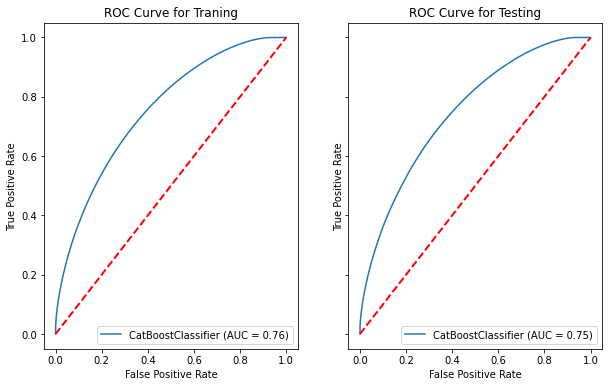

In [ ]:
perform_evaluate("Catboosting Scores train",catb_cfl,x_train,y_train)
perform_evaluate("Catboosting Scores test",catb_cfl,x_test,y_test)
plot_roc(catb_cfl,x_train, y_train,x_test, y_test)

#### LightBoosting

In [ ]:
lgb_cfl = lgb.LGBMClassifier(random_seed=123)
lgb_cfl.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_seed=123, random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
Mean_Trainin_Testing_score(lgb_cfl,x_train,y_train, x_test, y_test)

Mean Training Score: 69.25%
Mean Test Score: 69.27%


In [ ]:
# Select the best model with grid search
param_grid = {'max_depth': [20, 10],'learning_rate' : [0.5,0.01],'n_estimators': [100,500]}

start_time =datetime.now()
grid_search(lgb_cfl, param_grid,x_train,y_train,x_test, y_test )
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Mean Training Score: 70.07%
Mean Test Score: 72.33%
Best Parameter Combination Found During Grid Search: {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 500}
Duration: 0:17:40.603766


In [ ]:
start_time =datetime.now()
lgb_cfl = lgb.LGBMClassifier(random_seed=123, learning_rate=0.5,max_depth = 10, n_estimators=500)
lgb_cfl.fit(x_train, y_train)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
Mean_Trainin_Testing_score(lgb_cfl,x_train,y_train, x_test, y_test)

Duration: 0:00:55.327111
Mean Training Score: 72.54%
Mean Test Score: 72.33%


lightboosting Scores train
accuracy: 0.7254168102156282
precision: 0.7319036083131455
recall: 0.9206684295317514
f1: 0.8155052006241551
 
lightboosting Scores test
accuracy: 0.723290074216764
precision: 0.7307198355936606
recall: 0.9190555156533863
f1: 0.8141376276376726
 


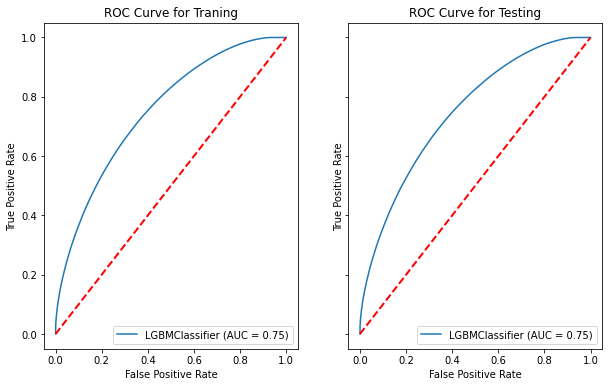

In [ ]:
perform_evaluate("lightboosting Scores train",lgb_cfl,x_train,y_train)
perform_evaluate("lightboosting Scores test",lgb_cfl,x_test,y_test)
plot_roc(lgb_cfl,x_train, y_train,x_test, y_test)

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8040230 entries, 6650700 to 5067380
Data columns (total 7 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   timestamp                 float64
 1   user_id                   float64
 2   content_id                float64
 3   task_container_id         float64
 4   user_answer               float64
 5   time                      float64
 6   question_had_explanation  float64
dtypes: float64(7)
memory usage: 490.7 MB


In [ ]:
x_train.drop(columns=['timestamp'], axis = 1, inplace = True)
x_test.drop(columns=['timestamp'],axis =1,inplace=True)
x_train = x_train.astype('float')
x_test = x_test.astype('float')
x_train2, x_val, y_train2, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=123)

print(x_train2.shape)
print(y_train2.shape)


(6432184, 6)
(6432184,)


### Neural Networks 


In [ ]:
nn_cf1 = Sequential(keras.Sequential([
    keras.layers.Flatten(input_shape=(6,)),
    keras.layers.Dense(10, activation=tf.nn.tanh),
    keras.layers.Dense(1, activation= tf.nn.sigmoid),
]))
nn_cf1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
nn_cf1.fit(x_train2, y_train2, epochs=20, batch_size=200, validation_data=(x_val, y_val))



Epoch 1/20
32161/32161 [==============================] - 34s 1ms/step - loss: 0.6418 - accuracy: 0.6589 - val_loss: 0.6413 - val_accuracy: 0.6596
Epoch 2/20
32161/32161 [==============================] - 33s 1ms/step - loss: 0.6418 - accuracy: 0.6590 - val_loss: 0.6413 - val_accuracy: 0.6596
Epoch 3/20
32161/32161 [==============================] - 32s 1ms/step - loss: 0.6419 - accuracy: 0.6588 - val_loss: 0.6413 - val_accuracy: 0.6596
Epoch 4/20
32161/32161 [==============================] - 33s 1ms/step - loss: 0.6418 - accuracy: 0.6588 - val_loss: 0.6413 - val_accuracy: 0.6596
Epoch 5/20
32161/32161 [==============================] - 33s 1ms/step - loss: 0.6416 - accuracy: 0.6592 - val_loss: 0.6416 - val_accuracy: 0.6596
Epoch 6/20
32161/32161 [==============================] - 33s 1ms/step - loss: 0.6418 - accuracy: 0.6590 - val_loss: 0.6413 - val_accuracy: 0.6596
Epoch 7/20
32161/32161 [==============================] - 33s 1ms/step - loss: 0.6417 - accuracy: 0.6591 - val_loss: 0

In [ ]:
# def simple_nn():
#   # construct Keras model
#   nn_cf1 = Sequential(keras.Sequential([
#     keras.layers.Flatten(input_shape=(6,)),
#     keras.layers.Dense(3, activation=tf.nn.tanh),
#     keras.layers.Dense(1, activation= tf.nn.sigmoid),
#     ]))
#    # compile Keras model
#   nn_cf1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy','AUC'])
#   # return Keras model
#   return nn_cf1


In [ ]:
# estimator = KerasClassifier(build_fn=simple_nn, 
#                                  epochs=2, 
#                                  batch_size=100, 
#                                  verbose=2)
# def is_classifier(estimator):
#     """Return True if the given estimator is (probably) a classifier.
#     Parameters
#     ----------
#     estimator : object
#         Estimator object to test.
#     Returns
#     -------
#     out : bool
#         True if estimator is a classifier and False otherwise.
#     """
#     return getattr(estimator, "_estimator_type", None) == "classifier"
#     classifier._estimator_type = "classifier"

In [ ]:
# is_classifier(estimator)

False

In [ ]:
x_test = x_test.astype(float)
train2_loss, train2_acc = nn_cf1.evaluate(x_test, y_test)

62815/62815 [==============================] - 42s 665us/step - loss: 0.6415 - accuracy: 0.6594


In [ ]:
# Calculate ROC_AUC
print("Train AUC:",roc_auc(nn_cf1,x_train2,y_train2))
print("Validation AUC:",roc_auc(nn_cf1,x_val,y_val))
print("Test AUC:",roc_auc(nn_cf1,x_test,y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


AUC: 50.00%
Train AUC: None


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


AUC: 50.00%
Validation AUC: None


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


AUC: 50.00%
Test AUC: None


#### Multi Neural Network

In [ ]:
nn_cf2 = Sequential(keras.Sequential([
    keras.layers.Flatten(input_shape=(6,)),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(10, activation = 'relu'),
    keras.layers.Dense(1, activation= 'sigmoid')
]))
nn_cf2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','AUC'])
nn_cf2.fit(x_train2, y_train2, epochs=20, batch_size=200, validation_data=(x_val, y_val))

Epoch 1/20
32161/32161 [==============================] - 52s 2ms/step - loss: 0.6420 - accuracy: 0.6588 - auc: 0.5002 - val_loss: 0.6413 - val_accuracy: 0.6596 - val_auc: 0.5000
Epoch 2/20
32161/32161 [==============================] - 49s 2ms/step - loss: 0.6418 - accuracy: 0.6589 - auc: 0.4998 - val_loss: 0.6413 - val_accuracy: 0.6596 - val_auc: 0.5000
Epoch 3/20
32161/32161 [==============================] - 49s 2ms/step - loss: 0.6417 - accuracy: 0.6590 - auc: 0.5003 - val_loss: 0.6413 - val_accuracy: 0.6596 - val_auc: 0.5000
Epoch 4/20
32161/32161 [==============================] - 49s 2ms/step - loss: 0.6419 - accuracy: 0.6588 - auc: 0.4998 - val_loss: 0.6413 - val_accuracy: 0.6596 - val_auc: 0.5000
Epoch 5/20
32161/32161 [==============================] - 49s 2ms/step - loss: 0.6417 - accuracy: 0.6591 - auc: 0.4997 - val_loss: 0.6413 - val_accuracy: 0.6596 - val_auc: 0.5000
Epoch 6/20
32161/32161 [==============================] - 50s 2ms/step - loss: 0.6417 - accuracy: 0.6591 

In [ ]:
train_loss, train_acc = nn_cf2.evaluate(x_train, y_train)

248829/248829 [==============================] - 160s 644us/step - loss: 0.6423 - accuracy: 0.6541


In [ ]:
test_loss, test_acc = nn_cf2.evaluate(x_test, y_test)

62208/62208 [==============================] - 40s 645us/step - loss: 0.6425 - accuracy: 0.6537


#### Embedding Neural Network

In [ ]:
cat_vars = ['user_answer', 'question_had_explanation','content_id', 'task_container_id']
cont_vars = ['time','user_id']

x_train_numpy = []
x_test_numpy = []

for cat in cat_vars:
    x_train_numpy.append(x_train2[cat].values)
    x_test_numpy.append(x_test[cat].values)
for con in cont_vars:
    x_train_numpy.append(x_train2[con].astype('float32').values)
    x_test_numpy.append(x_test[con].astype('float32').values)

y_train_numpy=y_train2.values
y_test_numpy=y_test.values

In [ ]:
cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = sampled_df_time_explanation[cat].nunique()# number of different type of the answers
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)
    cat_sizes[cat] = sampled_df_time_explanation[cat].max()


ins = []
concat = []
for cat in cat_vars:
    x = Input((1,), name=cat)
    ins.append(x)
    x = Embedding(cat_sizes[cat]+1, cat_embsizes[cat], input_length=1)(x)
    x = Reshape((cat_embsizes[cat],))(x)
    concat.append(x) 

for con in cont_vars:
  x = Input((1,), name=con)
  ins.append(x)
  concat.append(x)


y = Concatenate()(concat)
y = Dense(10, activation= 'softmax')(y)
y = Dense(1)(y)

# https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/174321
y = Activation("sigmoid")(y)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]


model = Model(ins, y)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC']) #'accuracy', 'AUC'
# model.trainable_variables
model.fit(x_train_numpy, y_train_numpy, 100, 20, validation_data=(x_test_numpy, y_test_numpy), callbacks=my_callbacks)
# model.summary()

Epoch 1/20
64322/64322 [==============================] - 446s 7ms/step - loss: 0.6422 - accuracy: 0.6590 - auc: 0.5006 - val_loss: 0.6414 - val_accuracy: 0.6594 - val_auc: 0.5000
Epoch 2/20
64322/64322 [==============================] - 439s 7ms/step - loss: 0.6418 - accuracy: 0.6589 - auc: 0.4998 - val_loss: 0.6414 - val_accuracy: 0.6594 - val_auc: 0.5000
Epoch 3/20
64322/64322 [==============================] - 440s 7ms/step - loss: 0.6416 - accuracy: 0.6592 - auc: 0.4997 - val_loss: 0.6414 - val_accuracy: 0.6594 - val_auc: 0.5000
Epoch 4/20
64322/64322 [==============================] - 438s 7ms/step - loss: 0.6416 - accuracy: 0.6592 - auc: 0.4997 - val_loss: 0.6415 - val_accuracy: 0.6594 - val_auc: 0.5000


In [ ]:
roc_auc(nn_cf1,x_test,y_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


AUC: 50.00%


### Conclusion 



In this notebook, I investigated different features that are able to affect students’ performance. For this reason, I considered the relation among the different variables and students' performance. Below I bring them in briefly. 
* Time spent on answering each question isn't related to correctness of the answers.
* Most of the students watched the explanation of the question when their answers were incorrect.
* As much as students answered more questions the number of the correct and incorrect answers increased.
* Number of wrong answers doesn't have any relation with total time spent watching lectures. 
* The number of the Lectures were watched has a direct relation with incorrect answers, which needs more investigation for the reasons.

For Modeling part,among all the models I have CatBoosting and LightBoosting have the best results.

|Algorithm |Accuracy |AUC |Time |
|-----------|----------|-----|------|
| XGBoosting | 69.32% | 67% |	11:50 |
|------------|--------|-----|-------|
| CatBoosting |	72.34% | 75% |	7:51 |
|-------------|--------|-----|-------|
| LightBoosting |	72.33% |	75% |	0:55 |
|---------------|--------|------|------|
| Multi Neural Network |	65.37% |	50% |	20:00 |
|----------------------|---------|------|-------|
| Embedding Neural Network |	65.94% |	50% |	2:00:00 |
|--------------------------|---------|------|---------|


### Future Works
* Evaluate students’ performance baise on different types of questions.
* Evaluate Lecture effect on correctness of answers
* Evaluate the background of students to the correctness of answers.
* Improving the prediction model by increasing AUC and Accuracy
